## 1. 数据预处理

In [1]:
import numpy as np
import scipy.io
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 数据读取函数定义  
注： mat 文件数据结构见 BatteryDataset 下的 txt 文件

In [2]:
def TimeConvert(hmm):
    """ 
        转换时间格式，将字符串转换成 datatime 格式  
    Args:
        hmm: 待输入的原始时间数据 (ndarray)
    Returns:
        标准化后的时间数据
    """
    year, month, day, hour, minute, second = \
                int(hmm[0]), int(hmm[1]), int(hmm[2]), \
                int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, 
                    hour=hour, minute=minute, second=second)

def LoadMat(mat_file):
    """ 
        加载 mat 文件数据  
    Args:
        mat_file: 待加载的文件路径 (string)
    Returns:
        读取的数据 (list)，其中每个元素为一个嵌套的 dict 类型
    """
    # 函数返回一个字典，其中键是 mat 文件中变量的名称，值是对应的数据数组
    data = scipy.io.loadmat(mat_file)
    # 从文件路径中提取文件名(不包含扩展名),用于访问字典的值
    fileName = mat_file.split('/')[-1].split('.')[0]
    col = data[fileName] # 获取整个数据(一个(1 x N)的四层结构化数组)
    col = col[0][0][0][0] # 去除冗余维度，访问包含所有循环数据的(616,)结构化数组
    size = col.shape[0] # 获取数组的大小(cycle 的数量)
    # print("data['B0005'].dtype:",data['B0005'].dtype,"value:",data['B0005'])
    # print("data['B0005'][0][0][0][0].dtype:",data['B0005'][0][0][0][0].dtype,
    #       "value:",data['B0005'][0][0][0][0])
    # print("data['B0005'][0][0][0][0][0][3][0].dtype:",data['B0005'][0][0][0][0][0][3][0].dtype,
    #       "value:",data['B0005'][0][0][0][0][0][3][0])

    data = []
    for i in range(size): # 遍历每个 cycle 的数据
        """ dtype.fields 方法用于访问 NumPy 结构化数组的字段信息，它返回一个字典，其中：
        键: 是结构化数组中每个字段的名称（字符串）；
        值: 是描述每个字段的元组，包含字段的数据类型、字节偏移量以及可选的标题。 """
        k = list(col[i][3][0].dtype.fields.keys()) # 获取结构化数组(data 字段)中所有子字段名称的列表
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance': # 去除 impedance 类型的数据
            for j in range(len(k)): # 遍历(data 字段)数组中的每个子字段
                t = col[i][3][0][0][j][0] # 获取该字段的数组数据
                l = [t[m] for m in range(len(t))] # 遍历提取数组中每个数据转为列表
                d2[k[j]] = l # 保存该数据及其对应的字段名称(以键值对的形式存在)
        # 将每个样本(cycle)的类型、温度、时间和数据存储到字典 d1 中
        d1['type'], d1['temp'], d1['time'], d1['data'] = \
            str(col[i][0][0]), int(col[i][1][0]), str(TimeConvert(col[i][2][0])), d2
        data.append(d1)

    return data

def GetBatteryCapacity(Battery):
    """ 
        获取单个锂电池的容量数据  
    Args:
        Battery: 单个电池的数据 (dict)
    Returns:
        获取的电池容量数据 (list)，包含两个元素，第一个为放电周期，第二个为容量数据
    """
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge': # 放电状态下获取容量数据
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

def GetBatteryValues(Battery, Type='charge'):
    """ 
        获取单个锂电池充电或放电时的测试数据(默认为充电状态的数据)  
    Args:
        Battery: 单个电池的数据 (dict)
        Type: 指定要读取的数据类型 (string)
    Returns:
        获取的电池数据， list 类型
    """
    data = []
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

In [3]:
# 用于测试数据
# Battery_list = 'B0005'
# dir_path = r'BatteryDataset/'

# path = dir_path + Battery_list + '.mat'
# data = LoadMat(path)

### 1.2 读取数据

In [4]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = r'BatteryDataset/'

capacity, charge, discharge = {}, {}, {}
for name in Battery_list:
    print('Loading Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = LoadMat(path)
    capacity[name] = GetBatteryCapacity(data) # 放电时的容量数据
    charge[name] = GetBatteryValues(data, 'charge') # 充电数据
    discharge[name] = GetBatteryValues(data, 'discharge') # 放电数据

Loading Dataset B0005.mat ...
Loading Dataset B0006.mat ...
Loading Dataset B0007.mat ...
Loading Dataset B0018.mat ...


### 1.3 数据展示

#### 1.3.1 不同电池容量 vs. 充放电周期曲线

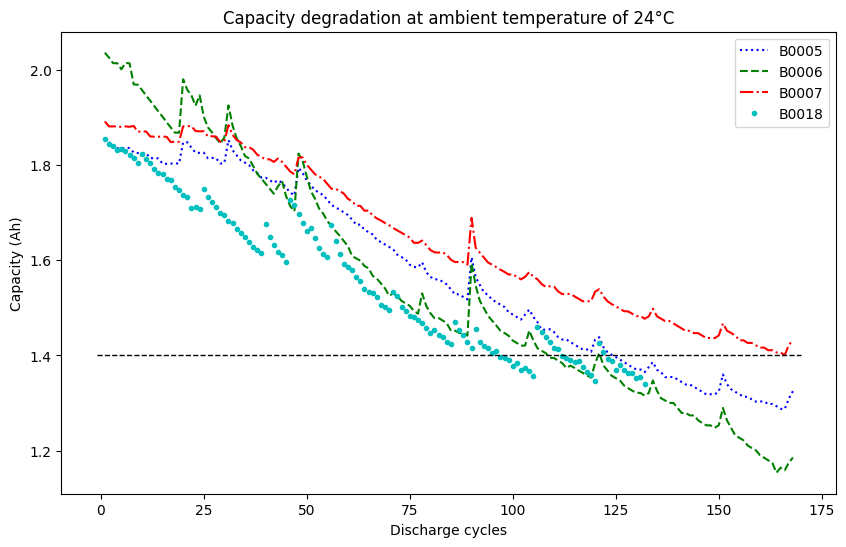

In [5]:
fig, ax = plt.subplots(1, figsize=(10, 6))
color_list = ['b:', 'g--', 'r-.', 'c.']
c = 0
for name,color in zip(Battery_list, color_list):
    df_result = capacity[name]
    ax.plot(df_result[0], df_result[1], color, label=name)
# 临界点直线(电池容量下降30%则认为报废)
plt.plot([-1,170],[2.0*0.7,2.0*0.7],c='black',lw=1,ls='--')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', 
       title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

#### 1.3.2 不同放电周期下，B0005号电池电压 vs. 放电周期曲线

[Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Voltage (V)'),
 Text(0.5, 1.0, 'Voltage vs. Time for Discharge Cycles')]

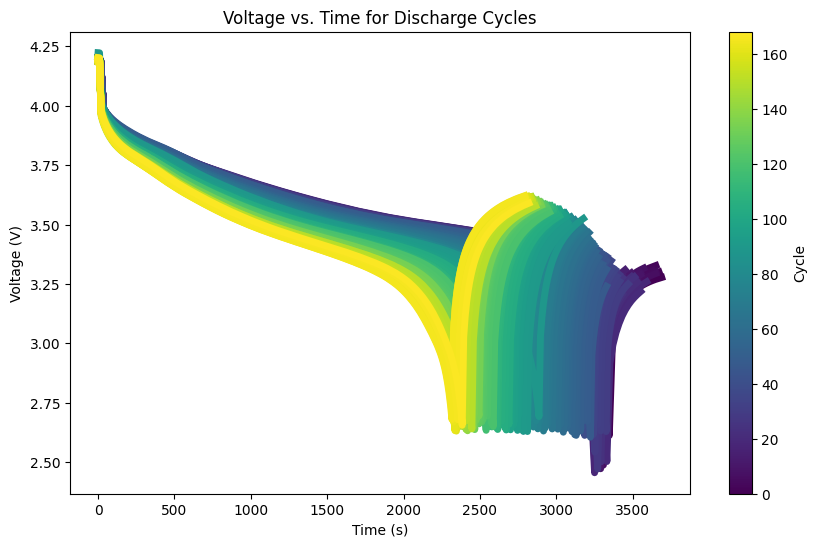

In [6]:
fig, ax = plt.subplots(1, figsize=(10, 6))
cmap = plt.get_cmap('viridis') # 选择合适的颜色映射, 'hsv', 'jet', 'viridis' 等

name = 'B0005' # 仅绘制第 B0005 号电池
for i, cycle_data in enumerate(discharge[name]):
    # 使用 plot 绘制，并根据循环次数着色
    ax.plot(cycle_data['Time'], cycle_data['Voltage_measured'], 
            c=cmap(i / len(discharge[name])), linewidth=5.0)
# 添加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, 
                           norm=plt.Normalize(vmin=0, vmax=len(discharge[name])))
sm.set_array([])  # 这是为了让colorbar工作，即使没有明确的映射数组
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Cycle') # 添加颜色条标签

ax.set(xlabel='Time (s)', ylabel='Voltage (V)', 
       title='Voltage vs. Time for Discharge Cycles')

#### 1.3.3 不同放电周期下，B0005号电池电流 vs. 充电周期曲线

[Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Current (V)'),
 Text(0.5, 1.0, 'Current vs. Time for discharge Cycles')]

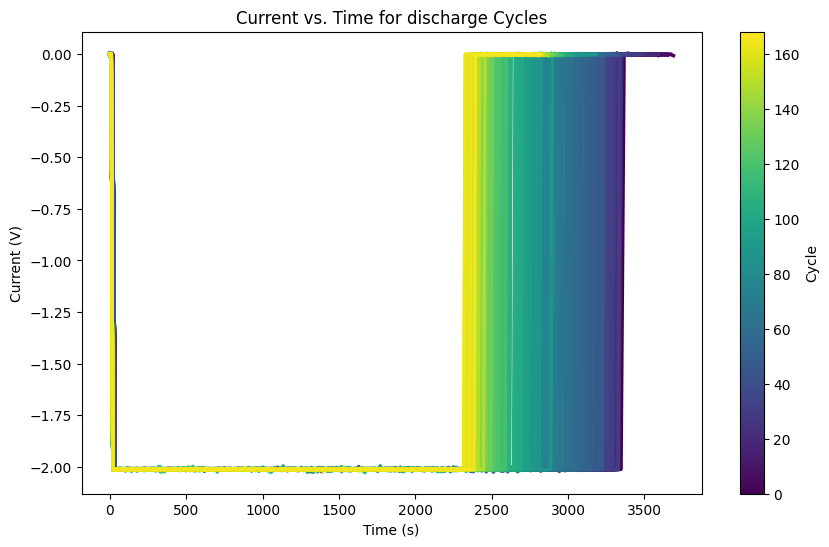

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 6))
cmap = plt.get_cmap('viridis') # 选择合适的颜色映射, 'hsv', 'jet', 'viridis' 等

name = 'B0005' # 仅绘制第 B0005 号电池
for i, cycle_data in enumerate(discharge[name]):
    # 使用 plot 绘制，并根据循环次数着色
    ax.plot(cycle_data['Time'], cycle_data['Current_measured'], 
            c=cmap(i / len(charge[name])), linewidth=2.5)
# 添加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, 
                           norm=plt.Normalize(vmin=0, vmax=len(discharge[name])))
sm.set_array([])  # 这是为了让colorbar工作，即使没有明确的映射数组
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Cycle') # 添加颜色条标签

ax.set(xlabel='Time (s)', ylabel='Current (V)', 
       title='Current vs. Time for discharge Cycles')

### 1.4 创建数据集

#### 1.4.1 数据集类定义

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from math import sqrt
import random
import os
# 注册设备
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
# 定义数据集类
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size):
        self.window_size = window_size
        self.data = torch.tensor(data, dtype=torch.float32).to(device)
        # 计算最大索引
        self.max_index = self.data.shape[0] - self.window_size - 1

    def __len__(self):
        return self.max_index + 1 #  返回有效数据长度

    def __getitem__(self, index):
        if index > self.max_index:
            raise IndexError(f"Index {index} is out of bounds."
                            f"Max index is {self.max_index}")
        x = self.data[index:index + self.window_size]
        y = self.data[index + self.window_size]
        return x.unsqueeze(1), y.unsqueeze(0) # 添加一个特征维度

#### 1.4.2 数据集获取函数定义

In [10]:
def get_split_dataset(data_dict, name, window_size=8, shuffle=True, 
             capacity_threshold=0.0, train_ratio=0.0, batch_size=32):
    """ 
        获取分割后的训练集和测试集 DataLoader  
    Args:
        data_dict: 字典类型，键为电池名称，值为包含电池信息的元组，
                其中第二个元素是容量数据列表 (list)
        name: 指定为测试集的电池数据名称 (str)  
        window_size: 用于创建时间序列的窗口大小 (int)  
        shuffle: 是否打乱训练集 (bool)  
        train_ratio: 用于训练数据划分的比例 (float32)
        capacity_threshold: 用于训练数据划分的阈值 (float32)
        batch_size: 训练的批大小 (int)  
    Returns:
        包含训练数据和测试数据 DataLoader 的元组。
    """
    data = data_dict[name][1]
    # 创建数据集
    dataset = TimeSeriesDataset(data, window_size)
    # 划分数据集
    if capacity_threshold > 0: # 优先使用阈值前的数据训练，阈值后的数据测试
        max_capacity = max(data)
        capacity = max_capacity * capacity_threshold
        point = next((i for i, val in enumerate(data) if val < capacity), None)
    else: # 否则按照指定的比例进行划分
        if (0 < train_ratio <= 1):
            point = int(len(data) * train_ratio)
        else:
            raise ValueError("Train ratio must be between 0 and 1.")
    # 使用 Subset 创建训练集和验证集，保持时间顺序
    train_dataset = Subset(dataset, range(point))
    test_dataset = Subset(dataset, range(point, len(dataset)))

    # 创建 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

def get_data(data_dict, name, window_size=8, shuffle=True, batch_size=32):
    """ 
        留一法获取训练集和测试集 DataLoader,每次留一个电池的数据作为测试集  
    Args:  
        data_dict: 字典类型，键为电池名称，值为包含电池信息的元组，
                其中第二个元素是容量数据列表 (list)  
        name: 指定为测试集的电池数据名称 (str)  
        window_size: 用于创建时间序列的窗口大小 (int)  
        shuffle: 是否打乱训练集 (bool)  
        batch_size: 训练的批大小 (int)  
    Returns:
        包含训练数据和测试数据 DataLoader 的元组。
    """
    test_data = data_dict[name][1]
    test_dataset = TimeSeriesDataset(test_data, window_size)

    train_datasets = []
    for k, v in data_dict.items():
        if k != name:
            dataset = TimeSeriesDataset(v[1], window_size)
            train_datasets.append(dataset)
    train_dataset = ConcatDataset(train_datasets) # 使用 ConcatDataset 拼接多个数据集

    # 创建 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 打印 DataLoader
    # print("train_loader_num:", len(train_loader.dataset))
    # print("test_loader_num:", len(test_loader.dataset))
    # for x, y in train_loader:
    #     print("x:", x.shape) # 输出: x: (batch_size, window_size, num_features)
    #     print("y:", y.shape) # 输出: y: (batch_size, 1)
    #     break
    return train_loader, test_loader


In [11]:
# window_size = 8
# for i in range(len(Battery_list)):
#     name = Battery_list[i]
#     get_data(capacity, name, window_size)

## 2. 模型建立

In [12]:
# 定义CNN层
class CNNLayer(nn.Module):
    def __init__(self, num_channels, out_dim, kernel_size=1):
        super(CNNLayer, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_channels, 
                               out_channels=out_dim, 
                               kernel_size=kernel_size)
    
    def forward(self, x):
        x = F.relu(self.conv1(x)) # x.shape([batch_size, out_dim, 1])
        return x

# 定义LSTM层
class LSTMLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, bidirectional):
        super(LSTMLayer, self).__init__()
        self.hidden_size = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, 
                            num_layers=num_layers, batch_first=True, 
                            bidirectional=bidirectional)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2 if self.bidirectional else 
                         self.num_layers, x.size(0), 
                         self.hidden_size).to(device) # 初始化隐藏状态h0
        c0 = torch.zeros(self.num_layers*2 if self.bidirectional else 
                         self.num_layers, x.size(0), 
                         self.hidden_size).to(device)  # 初始化记忆状态c0
        output, (hidden, cell) = self.lstm(x, (h0, c0))
        # output.shape([batch_size, 1, hidden_dim*2 if bidirectional else hidden_dim])
        return output

# 定义Attention层
class AttentionLayer(nn.Module):
    def __init__(self, feature_dim, step_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(feature_dim, step_dim)
        self.context_vector = nn.Linear(step_dim, 1, bias=False)

    def forward(self, x):
        # 将输出值限制在 -1 到 1 之间，shape：[batch_size, feature_dim, step_dim]
        attention_weights = torch.tanh(self.attention(x))
        # 为每个时间步计算一个未归一化的注意力权重，shape：[batch_size, 1]
        attention_weights = self.context_vector(attention_weights).squeeze(2)
        attention_weights = F.softmax(attention_weights, dim=1) # 对权重归一化
        # 将注意力权重与输入 x 相乘，shape：[batch_size, feature_dim]
        context_vector = torch.bmm(attention_weights.unsqueeze(1), x).squeeze(1)
        return context_vector, attention_weights

# 建立组合模型 CNN-LSTM-Attention
class CLAM(nn.Module):
    def __init__(self, num_channels, out_dim, kernel_size, hidden_dim,
                  num_layers, bidirectional, step_dim, output_dim):
        super(CLAM, self).__init__()
        self.cnn = CNNLayer(num_channels, out_dim, kernel_size)
        self.lstm = LSTMLayer(out_dim, hidden_dim, 
                              num_layers, bidirectional)
        self.attention = AttentionLayer(hidden_dim * 2 if bidirectional else 
                                        hidden_dim, step_dim)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    
    def forward(self, x):
        x = x.transpose(1, 2) # 交换维度
        x = self.cnn(x)
        x = x.transpose(1, 2)
        x = self.lstm(x)
        x, _ = self.attention(x)
        x = self.fc(x)
        # x = self.fc(x[:, -1, :]) # 取序列最后一个时间步的输出作为预测
        return x
    
    # 建立组合模型 CNN-LSTM
class CLM(nn.Module):
    def __init__(self, num_channels, out_dim, kernel_size, hidden_dim, 
                 num_layers, bidirectional, output_dim):
        super(CLM, self).__init__()
        self.cnn = CNNLayer(num_channels, out_dim, kernel_size)
        self.lstm = LSTMLayer(out_dim, hidden_dim, 
                              num_layers, bidirectional)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    
    def forward(self, x):
        x = x.transpose(1, 2) # 交换维度
        x = self.cnn(x)
        x = x.transpose(1, 2)
        x = self.lstm(x)
        # x = self.fc(x)
        x = self.fc(x[:, -1, :]) # 取序列最后一个时间步的输出作为预测
        return x

# 建立组合模型 LSTM-Attention
class LAM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, 
                 bidirectional, step_dim, output_dim):
        super(LAM, self).__init__()
        self.lstm = LSTMLayer(input_dim, hidden_dim, 
                              num_layers, bidirectional)
        self.attention = AttentionLayer(hidden_dim * 2 if bidirectional else 
                                        hidden_dim, step_dim)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.lstm(x)
        x, _ = self.attention(x)
        x = self.fc(x)
        # x = self.fc(x[:, -1, :]) # 取序列最后一个时间步的输出作为预测
        return x

    # 建立模型 LSTM
class LM(nn.Module):
    def __init__(self, input_dim, hidden_dim, 
                 num_layers, bidirectional, output_dim):
        super(LM, self).__init__()
        self.lstm = LSTMLayer(input_dim, hidden_dim, 
                              num_layers, bidirectional)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.lstm(x)
        # x = self.fc(x)
        x = self.fc(x[:, -1, :]) # 取序列最后一个时间步的输出作为预测
        return x

## 3. 模型训练

### 3.1 训练函数定义

#### 3.1.1 模型获取函数和批训练函数定义

In [ ]:
def get_model(num_channels, out_dim, kernel_size, feature_dim, hidden_dim, 
              num_layers, bidirectional, step_dim, output_dim, model_name='CBiLAM'):
    """ 
        获取模型，并指定优化器和损失计算方法
    Args:
        num_channels: 输入模型的通道数，即窗口大小
        out_dim: 卷积的输出特征维度
        feature_dim: 输入数据的特征维度
        kernel_size: 卷积核大小
        hidden_dim: LSTM隐藏状态维度
        num_layers: LSTM层的数目
        bidirectional: 是否使用双向LSTM
        step_dim: 时间步维度
        output_dim: 输出维度(预测目标维度)
        model_name: 指定的模型名称
    Returns:
        指定的模型、损失函数和优化器的元组
    """
    if model_name == 'CBiLA':
        model = CLAM(num_channels, out_dim, kernel_size, hidden_dim, 
                    num_layers, bidirectional, step_dim, output_dim)
    elif model_name == 'CBiL':
        model = CLM(num_channels, out_dim, kernel_size, hidden_dim, 
                    num_layers, bidirectional, output_dim)
    elif model_name == 'BiLAM':
        model = LAM(feature_dim, hidden_dim, num_layers, 
                    bidirectional, step_dim, output_dim)
    elif model_name == 'BiLSTM':
        model = LM(feature_dim, hidden_dim, num_layers, 
                    bidirectional, output_dim)
    else:
        model = LM(feature_dim, hidden_dim, num_layers, 
                   bidirectional=False, output_dim=output_dim)
    loss_fn = nn.MSELoss() # 使用均方误差
    optimizer = optim.Adam(model.parameters(), 
                           lr=0.001, betas=(0.5,0.999)) # 使用Adam优化器
    return model, loss_fn, optimizer


def train_batch(x, y, model, optimizer, loss_fn):
    """ 
        批训练函数
    Args:
        x: 输入的训练数据
        y: 输入的真实目标数据
        model: 指定的模型
        optimizer: 指定的优化器
        loss_fn: 指定的损失函数
    Returns:
        计算的损失标量
    """
    model.train() # 设置为训练
    prediction = model(x) # 输入数据
    # print("Prediction shape:", prediction.shape)
    batch_loss = loss_fn(prediction, y) # 计算损失
    batch_loss.backward() # 进行反向传播
    optimizer.step() # 梯度下降
    optimizer.zero_grad() # 清空梯度
    return batch_loss.item()

#### 3.1.2 评估函数定义

In [ ]:
def relative_error(y_test, y_predict, threshold):
    """ 
        计算预测值与真实值之间在达到特定阈值时的相对误差  
    Args:
        y_test: 真实的电池容量衰减数据
        y_predict: 模型预测的电池容量衰减数据
        threshold: 定义电池寿命结束的容量阈值
    Returns:
        计算的相对误差分数
    """
    true_re, pred_re = len(y_test), 0
    
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1 # 第一个下降到阈值前的数据的放电次数
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold:
            pred_re = i - 1 # 预测的次数
            break
    # 计算相对误差，公式为 |真实剩余寿命 - 预测剩余寿命| / 真实剩余寿命
    score = abs(true_re - pred_re) / true_re
    if score > 1: score = 1
    
    return score


def evaluation(y_test, y_predict):
    """ 
        计算模型的评价指标
    Args:
        y_test: 真实的电池容量衰减数据
        y_predict: 模型预测的电池容量衰减数据
    Returns:
        一个字典，包含所有计算的指标
    """
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    crmsd = np.sqrt(np.mean(((y_test - np.mean(y_test)) - \
                             (y_predict - np.mean(y_predict)))**2))
    mad = np.median(np.abs(y_test - y_predict))
    mae = mean_absolute_error(y_test, y_predict)
    mbe = np.abs(np.mean(y_predict - y_test))
    rsquare = r2_score(y_test, y_predict)
    metrics_dict = {
        "RMSE": rmse,
        "CRMSD": crmsd,
        "MAD": mad,
        "MAE": mae,
        "MBE": mbe,
        "R2": rsquare
    }
    return metrics_dict

def setup_seed(seed):
    """ 
        设置环境的随机种子，保证训练结果的一致性  
    Args:
        seed: 指定的随机种子
    Returns:
        None.
    """
    np.random.seed(seed) # 设置 NumPy 模块的随机种子
    random.seed(seed) # 设置 Python 内置 random 模块的随机种子
    os.environ['PYTHONHASHSEED'] = str(seed) # 设置 Python 的哈希种子
    torch.manual_seed(seed) # 设置 PyTorch 的随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前 GPU 设置随机种子
        torch.cuda.manual_seed_all(seed) # 为所有可用的 GPU 设置随机种子
        torch.backends.cudnn.benchmark = False # 禁用 cuDNN 的 benchmark 模式
        torch.backends.cudnn.deterministic = True # 启用 cuDNN 的确定性模式

### 3.2 开始训练

In [ ]:
window_size = 8
out_dim = 32
feature_dim = 1
kernel_size = 5
hidden_dim = 64
num_layers = 1
bidirectional = True
step_dim = 32
output_dim = 1

Rated_Capacity = 2.0 # 额定容量
epochs = 200 # 训练次数
seed = 42 # 随机种子
metric = 'rmse' # 评估指标
model_list = ['CBiLA', 'CBiL', 'BiLA', 'BiLSTM', 'LSTM']

model, loss_fn, optimizer = get_model(feature_dim, out_dim, kernel_size, feature_dim,
                                        hidden_dim, num_layers, bidirectional,
                                        step_dim, output_dim, model_name='CBiLA')
setup_seed(seed) # 设置种子

score_list, result_list = [], []
for i in range(len(Battery_list)): # 四折交叉验证
    name = Battery_list[i]
    train_loader, test_loader = get_data(capacity, name, window_size)
    model = model.to(device) # 注册模型到设备

    train_loss = [0]
    metrics, re = {}, 1
    score, best_score = float(1), float(1)
    best_pred = []
    for epoch in range(epochs):
        train_epoch_loss = []
        model.train()  # 设置为训练模式
        for index, batch in enumerate(iter(train_loader)):
            x, y = batch
            # 归一化
            x /= torch.tensor(Rated_Capacity).to(device)
            y /= torch.tensor(Rated_Capacity).to(device)
            batch_loss = train_batch(x, y, model, optimizer, loss_fn)
            train_epoch_loss.append(batch_loss)

        train_epoch_loss = np.array(train_epoch_loss).mean()
        train_loss.append(train_epoch_loss)

        if (epoch + 1) % 10 == 0:
            model.eval() # 设置为验证模式
            tesy_pred, test_y = [], []
            with torch.no_grad():
                for index, batch in enumerate(iter(test_loader)):
                    x, y = batch
                    # 归一化
                    x /= torch.tensor(Rated_Capacity).to(device)
                    y /= torch.tensor(Rated_Capacity).to(device)
                    pred = model(x)

                    # 将预测值和真实值转换为 NumPy 数组并展平
                    pred_np = (pred * Rated_Capacity).cpu().numpy().flatten()
                    y_np = (y * Rated_Capacity).cpu().numpy().flatten()
                    tesy_pred.extend(pred_np)
                    test_y.extend(y_np)
            metrics = evaluation(np.array(test_y), np.array(tesy_pred))
            re = relative_error(np.array(test_y), 
                                np.array(tesy_pred), Rated_Capacity * 0.7)
            print(f"Epoch {epoch+1}/{epochs} Train Loss: {train_epoch_loss:.4f}", 
                  f"RMSE: {metrics['RMSE']:.4f} RE: {re:.4f}")

            # 使用验证集分数进行早停
            score = re if metric == 're' else metrics['RMSE']
            if (batch_loss < 1e-4) and (score < best_score):
                best_score = score
                best_pred = tesy_pred
                # break

    score_list.append(best_score)
    result_list.append(list(tesy_pred))
    print("score_list for 4 types of batteries:\n", np.array(score_list))
    print(metric + ': for this seed: {:<6.4f}'.format(np.mean(np.array(score_list))))
    print('------------------------------------------------------------------')

Epoch 10/200 Train Loss: 0.0004 RMSE: 0.0601 RE: 0.1215
Epoch 20/200 Train Loss: 0.0006 RMSE: 0.1016 RE: 0.1963
Epoch 30/200 Train Loss: 0.0007 RMSE: 0.0386 RE: 0.0935
Epoch 40/200 Train Loss: 0.0006 RMSE: 0.0735 RE: 0.1495
Epoch 50/200 Train Loss: 0.0006 RMSE: 0.0763 RE: 0.1495
Epoch 60/200 Train Loss: 0.0005 RMSE: 0.0260 RE: 0.0374
Epoch 70/200 Train Loss: 0.0002 RMSE: 0.0248 RE: 0.0374
Epoch 80/200 Train Loss: 0.0003 RMSE: 0.0316 RE: 0.0561
Epoch 90/200 Train Loss: 0.0005 RMSE: 0.0415 RE: 0.0748
Epoch 100/200 Train Loss: 0.0005 RMSE: 0.0226 RE: 0.0093
Epoch 110/200 Train Loss: 0.0003 RMSE: 0.0208 RE: 0.0093
Epoch 120/200 Train Loss: 0.0026 RMSE: 0.0273 RE: 0.0000
Epoch 130/200 Train Loss: 0.0003 RMSE: 0.0250 RE: 0.0374
Epoch 140/200 Train Loss: 0.0002 RMSE: 0.0261 RE: 0.0467
Epoch 150/200 Train Loss: 0.0003 RMSE: 0.0352 RE: 0.0748
Epoch 160/200 Train Loss: 0.0002 RMSE: 0.0592 RE: 0.1215
Epoch 170/200 Train Loss: 0.0002 RMSE: 0.0465 RE: 0.1028
Epoch 180/200 Train Loss: 0.0003 RMSE: 0

### 3.3 预测容量曲线

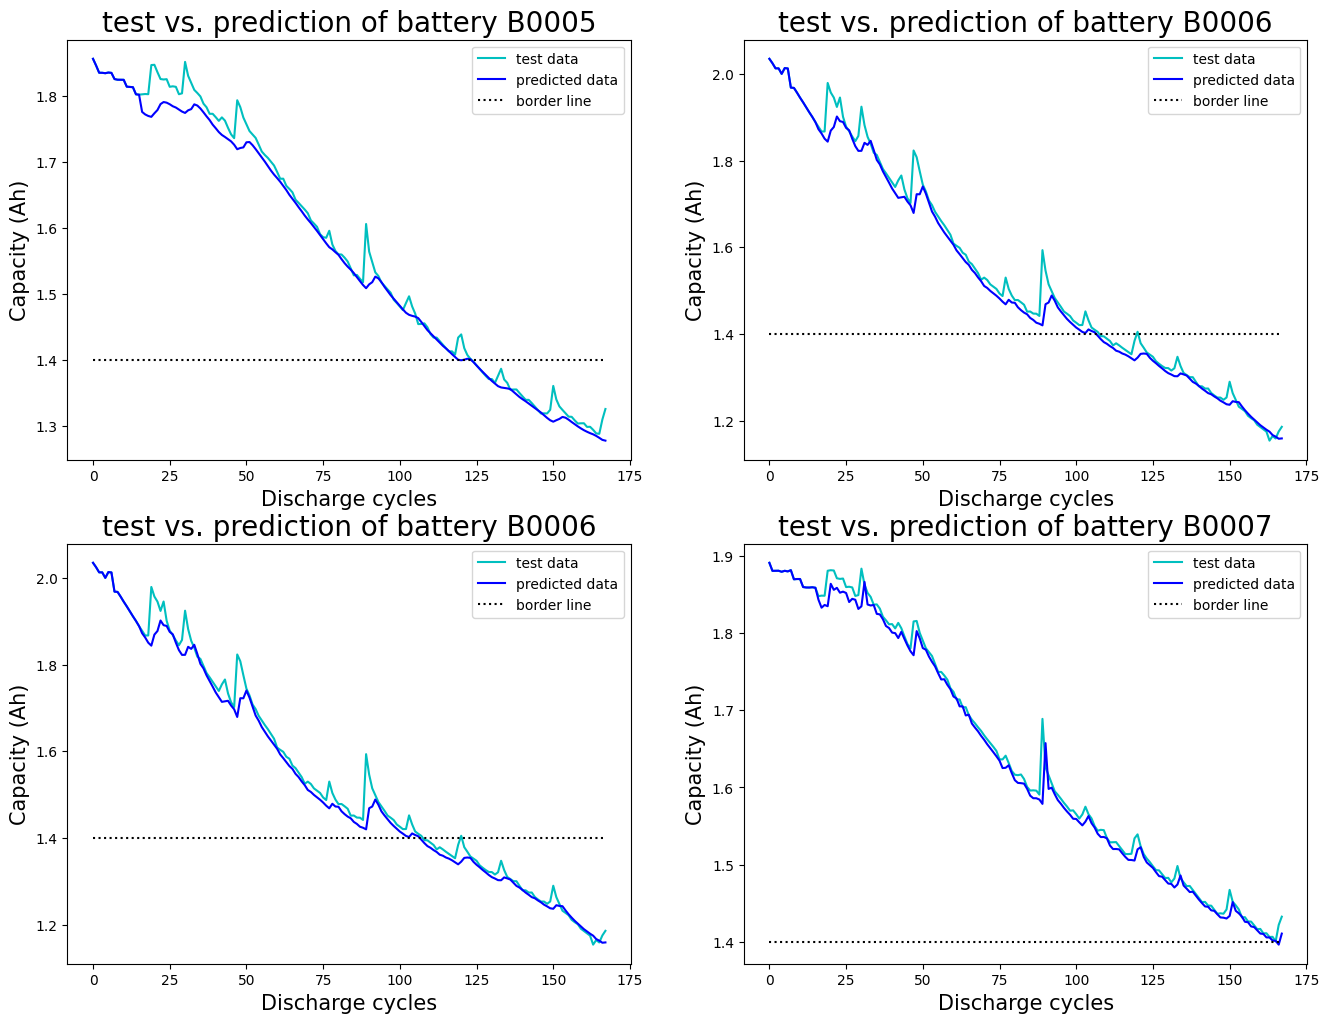

In [16]:
fig,ax = plt.subplots(2, 2, figsize=(16, 12))

for i in range(2):
    for j in range(2):
        t = i + j
        battery_name = Battery_list[t]
        test_data = capacity[battery_name][1]
        predict_data = test_data[:window_size] + result_list[t]
        x = [t for t in range(len(test_data))]
        threshold = [Rated_Capacity*0.7] * len(test_data)
        ax[i][j].plot(x, test_data, 'c', label='test data')
        ax[i][j].plot(x, predict_data, 'b', label='predicted data')
        ax[i][j].plot(x, threshold, 'black', ls=':', label='border line')
        ax[i][j].legend()
        ax[i][j].set_xlabel('Discharge cycles', fontsize=15)
        ax[i][j].set_ylabel('Capacity (Ah)', fontsize=15)
        ax[i][j].set_title('test vs. prediction of battery ' + battery_name, fontsize=20)
plt.show()